# YOLOv5






## Импорт библиотек

In [30]:
# Для загрузки и анализа данных
import os
import tarfile
import urllib.request
import glob
import utils
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn import preprocessing
from time import time

# Для работы с изображениями и построения модели
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageDraw
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                            Compose, GaussNoise)
import cv2
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import display

## Загрузка данных

К сожалению, по данной ссылке (`pjreddie.com`) у меня архив полностью не скачивается, поэтому я буду использовать эти же данные, но скачанные с `ultralytics`.

In [ ]:
# Загрузка датасета
#if not os.path.exists("VOCdevkit"):
#    if not os.path.exists("VOC.tar"):
#        urllib.request.urlretrieve(
#            "https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar", "VOC.tar"
#        )
#    with tarfile.open("VOC.tar") as tar:
#        tar.extractall()

In [2]:
# Загрузка датасета
if not os.path.exists("/content/VOCdevkit"):
    urllib.request.urlretrieve(
        "https://github.com/ultralytics/yolov5/releases/download/v1.0/VOCtrainval_11-May-2012.zip",
        "VOCtrainval_11-May-2012.zip"
    )

In [3]:
%%capture
# разархивируем скачанный датасет
!unzip VOCtrainval_11-May-2012.zip

In [10]:
def xml_to_csv(path = 'VOCdevkit/VOC2012/Annotations/'):
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '/2010*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = obj.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     int(root.find('size')[2].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'channels', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [11]:
xml_df = xml_to_csv()
xml_df.to_csv('VOC_2010.csv', index=None)
print('Конвертация прошла успешно.')

100%|██████████| 3503/3503 [00:00<00:00, 10444.79it/s]

Конвертация прошла успешно.


In [12]:
xml_df = xml_df[:100]

In [13]:
xml_df.head()

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
0,2010_004661.jpg,3,500,398,car,12,171,385,482
1,2010_004661.jpg,3,500,398,car,248,140,308,183
2,2010_004661.jpg,3,500,398,car,299,218,374,258
3,2010_004661.jpg,3,500,398,car,177,165,235,203
4,2010_004661.jpg,3,500,398,person,5,175,44,214


In [14]:
print(f'Общее количество объектов {xml_df.shape[0]}')
print(f'Количество изображений в датафрэйме {len(np.unique(xml_df["filename"]))}')

Общее количество объектов 100
Количество изображений в датафрэйме 53


## Обработка данных

Закодируем классы обьектов.

In [15]:
le = preprocessing.LabelEncoder()
xml_df['class'] = le.fit_transform(xml_df['class'])

In [16]:
xml_df.head()

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
0,2010_004661.jpg,3,500,398,5,12,171,385,482
1,2010_004661.jpg,3,500,398,5,248,140,308,183
2,2010_004661.jpg,3,500,398,5,299,218,374,258
3,2010_004661.jpg,3,500,398,5,177,165,235,203
4,2010_004661.jpg,3,500,398,11,5,175,44,214


Сохраним кодировку классов в переменной mapping.

In [17]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [18]:
mapping

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'bottle': 3,
 'bus': 4,
 'car': 5,
 'cat': 6,
 'chair': 7,
 'diningtable': 8,
 'dog': 9,
 'motorbike': 10,
 'person': 11,
 'sheep': 12,
 'sofa': 13,
 'train': 14,
 'tvmonitor': 15}

Теперь нам нужно привести наши данные к формату **YOLOv5**.

Аннотация каждого объекта должна сожержать следующую информацию:

`Class X Y Width Height`

![picture](https://drive.google.com/uc?export=view&id=1yUJt5XTvYo4MbWxKAxhPdCk-yCnQ1AEz)


Для этого воспользуемся вспомогательной функцией `convert_to_yolov5`.



In [20]:
def convert_to_yolov5(df, unique_img_names):

    df_array = np.array(df)

    # Для каждого объкта
    for i in range(len(df)):
        print_buffer = []

        point =  df_array[i]
        img_name = point[0]

        # Для каждого уникального изображения
        for unique_img_name in unique_img_names:
           if img_name == unique_img_name:
              class_id = point[4]

              # Преобразуем координаты bbox
              X = (point[5] + point[7]) / 2
              Y = (point[6] + point[8]) / 2
              Width    = (point[7] - point[5])
              Height   = (point[8] - point[6])

              # Нормализуем координаты
              image_c, image_w, image_h = point[1], point[2], point[3]
              X /= image_w
              Y /= image_h
              Width    /= image_w
              Height   /= image_h

              # Запишем информацию о bbox в файл
              print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, X, Y, Width, Height))

        # Дадим имя файлам, которые хотим сохранить
        save_file_name = os.path.join("/content/VOCdevkit/VOC2012/JPEGImages/", img_name.replace("jpg", "txt"))

        # Сохраним аннотации на диск
        print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [21]:
# Для начала выделим список уникальных имен изображений
unique_img_names = xml_df['filename'].unique()
print(len(unique_img_names))

53


In [22]:
# Получим аннотации в новом формате
convert_to_yolov5(xml_df, unique_img_names)

Давайте протестируем трансформированные аннотиции с помощью визуализации.

In [24]:
class_id_to_name_mapping = dict(zip(mapping.values(), mapping.keys()))

In [25]:
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    print(transformed_annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))], fill="#000")


    plt.imshow(np.array(image))
    plt.show()

In [26]:
# Выберем рандомную аннотацию
annotation_random= !ls /content/VOCdevkit/VOC2012/JPEGImages/*txt | shuf -n 1

In [27]:
annotation_random

['/content/VOCdevkit/VOC2012/JPEGImages/2010_006535.txt']

[[11.     0.359  0.599  0.636  1.135]]


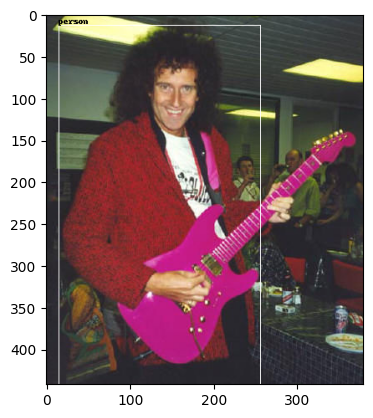

In [28]:
# Выберем рандомную аннотацию
annotation_file = annotation_random[0]
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

Обученная модель находится в классе hub библиотеки `torch`.

Давайте посмотрим на предсказания модели для нашей рандомной картинки.

In [29]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

img = annotation_random[0].replace("txt", "jpg")

# Inference
results = model(img)

# Results
results.print()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


requirements: Ultralytics requirement ['gitpython>=3.1.30'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 118.0 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 8.0s, installed 1 package: ['gitpython>=3.1.30']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2024-2-3 Python-3.10.12 torch-2.1.0+cu121 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 128MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
image 1/1: 442x379 5 persons, 1 sports ball, 2 bottles, 1 bowl, 1 potted plant, 1 dining table
Speed: 42.1ms pre-process, 481.4ms inference, 40.2ms NMS per image at shape (1, 3, 640, 576)


## ЗАДАНИЕ

Обучите модель **yolov5**,  используя готовый `train.py` файл репозитория https://github.com/ultralytics/yolov5.git.

Для данной модели изображения и классы объектов должны находиться в папках images и labels, соответсвенно.

Протестируйте модель на валидациооной выборке и выведите на экран полученные изображения с bbox и классами объектов.

In [ ]:
#--- YOUR CODE HERE ---

Сделайте сравнение текущей модели с Faster RCNN по скорости и качетсву.

In [31]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install

display = utils.notebook_init()  # checks

YOLOv5 🚀 2024-2-3 Python-3.10.12 torch-2.1.0+cu121 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.1/107.7 GB disk)


In [32]:
!python train.py --img 640 --batch 16 --epochs 3 --data ../VOC.yaml --weights yolov5s.pt --cache

2024-02-03 10:27:13.339822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 10:27:13.339938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 10:27:13.343537: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=../VOC.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=3, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optim